# XRPlace: Распознавание дверей, окон и назначения помещений на плане


## Цель проекта

Компания **XRPlace** разрабатывает интерактивные 3D-модели квартир и домов, которые можно осматривать в браузере от первого лица.  
Для автоматизации создания 3D-сцен необходимо автоматически определять **дверные и оконные проёмы**, а также, по возможности, **назначение помещений** по изображениям архитектурных планов.

---

## Задачи проекта

- Исследование открытых датасетов планов помещений.
- Выбор предобученной модели и типа задачи:
  - Object Detection / Segmentation — для дверей и окон,
  - Classification — для типа помещения.
- Обучение модели на открытых данных.
- Постпроцессинг: преобразование масок/bbox в координаты.
- Тестирование на пользовательских данных.
- Разработка интерактивного Gradio-приложения.
- Анализ ошибок модели и улучшение.

---

## Используемый стек

- **YOLOv11** — детекция и сегментация.
- **Roboflow** — загрузка датасетов.
- **OpenCV**, **Pillow**, **NumPy** — обработка изображений.
- **matplotlib**, **seaborn** — визуализация.
- Метрики: **IoU**, **mAP**.
---


In [12]:
!pip install albumentations opencv-python tqdm -q

In [13]:
%pip install ultralytics  -q

Note: you may need to restart the kernel to use updated packages.


In [9]:
import ultralytics
print(ultralytics.__version__)

8.3.158


In [19]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from PIL import Image, ImageDraw
import yaml
from ultralytics import YOLO
import importlib 
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy as np


In [15]:
def eda_df(path):
    base_path = Path(path)
    # Директории
    train_img_dir = base_path / "train" / "images"
    train_lbl_dir = base_path / "train" / "labels"
    yaml_path = base_path / "data.yaml" 

    # список изображений и аннотаций
    image_files = (
        glob.glob(str(train_img_dir / "*.jpg")) + 
        glob.glob(str(train_img_dir / "*.JPG")) +
        glob.glob(str(train_img_dir / "*.png")) +
        glob.glob(str(train_img_dir / "*.PNG"))
    )

    label_files = glob.glob(str(train_lbl_dir / "*.txt"))

    print(f"Кол-во изображений: {len(image_files)}")
    print(f"Кол-во файлов аннотаций: {len(label_files)}")
    print("---")

    # Размеры изображений
    image_sizes = []
    for img_path in image_files:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # (width, height)

    df_sizes = pd.DataFrame(image_sizes, columns=["width", "height"])
    print(df_sizes.describe())

    # Распределение по классам
    class_counts = Counter()
    for lbl_file in label_files:
        with open(lbl_file, "r") as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1
    print("---\n\nРаспределение объектов по классам:\n")
    for class_id, count in sorted(class_counts.items()):
        print(f"Класс {class_id}: {count} объектов")

    # Загрузка классов из data.yaml
    with open(yaml_path, "r") as f:
        data_cfg = yaml.safe_load(f)

    class_names = data_cfg.get("names", {})  
    print("---")
    print("Классы:", class_names)

    return [train_img_dir, train_lbl_dir, class_names],   # возвращаем Path-объект

def show_image_labels(train_img_dir, train_lbl_dir, class_names, img_index):
    # ==== Выбор изображения ====
    img_path = sorted(list(train_img_dir.glob("*.jpg")) 
                      + list(train_img_dir.glob("*.png")))[img_index]
    img_name = img_path.stem
    label_path = train_lbl_dir / f"{img_name}.txt"

    # ==== Загрузка изображения ====
    image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(image)
    w_img, h_img = image.size

    # ==== Чтение и отрисовка аннотаций ====
    with open(label_path, "r") as f:
        for line in f.readlines():
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            
            # Преобразуем YOLO координаты в абсолютные
            x0 = (x_center - width / 2) * w_img
            y0 = (y_center - height / 2) * h_img
            x1 = (x_center + width / 2) * w_img
            y1 = (y_center + height / 2) * h_img

            class_name = class_names[int(class_id)] if int(class_id) in class_names else str(int(class_id))

            # Отрисовка прямоугольника и подписи
            draw.rectangle([x0, y0, x1, y1], outline="red", width=2)
            draw.text((x0, y0 - 10), class_name, fill="red")
        # ==== Отображение результата ====
        plt.figure(figsize=(10, 8))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Аннотации для: {img_name}")
        plt.show()

def plot_box_distributions(labels_dir):
    """
    Строит гистограммы распределения ширины, высоты и площади боксов
    для каждого класса по YOLO-аннотациям из .txt файлов.

    :param labels_dir: Путь к папке с аннотациями в YOLO-формате.
    """
    box_stats = {}

    # Чтение всех файлов
    for filename in os.listdir(labels_dir):
        if filename.endswith(".txt"):
            with open(os.path.join(labels_dir, filename), 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    class_id, _, _, w, h = parts
                    class_id = int(class_id)
                    w = float(w)
                    h = float(h)
                    area = w * h

                    if class_id not in box_stats:
                        box_stats[class_id] = {'widths': [], 
                                               'heights': [], 
                                               'areas': [],
                                               'filename':[]}

                    box_stats[class_id]['widths'].append(w)
                    box_stats[class_id]['heights'].append(h)
                    box_stats[class_id]['areas'].append(area)
                    box_stats[class_id]['filename'].append(filename)

    if not box_stats:
        print("Нет данных для построения гистограмм.")
        return

    # Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    bins = 50

    for class_id, stats in box_stats.items():
        axes[0].hist(stats['widths'], bins=bins, alpha=0.5, label=f'Класс {class_id}')
        axes[1].hist(stats['heights'], bins=bins, alpha=0.5, label=f'Класс {class_id}')
        axes[2].hist(stats['areas'], bins=bins, alpha=0.5, label=f'Класс {class_id}')

    # Подписи и оформление
    axes[0].set_title("Распределение ширины")
    axes[0].set_xlabel("Ширина")
    axes[0].set_ylabel("Количество")

    axes[1].set_title("Распределение высоты")
    axes[1].set_xlabel("Высота")

    axes[2].set_title("Распределение площади")
    axes[2].set_xlabel("Площадь")

    for ax in axes:
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


# Загрузка датасета (окна и двери)

In [125]:
data_path ="../data/train_layouts_2"

In [126]:
train = eda_df(data_path)

Кол-во изображений: 583
Кол-во файлов аннотаций: 583
---
             width       height
count   583.000000   583.000000
mean    885.387650   798.583190
std     484.096254   362.833976
min     173.000000   278.000000
25%     545.000000   539.000000
50%     747.000000   711.000000
75%    1060.000000   923.000000
max    2048.000000  2048.000000
---

Распределение объектов по классам:

Класс 0: 5154 объектов
Класс 1: 3790 объектов
---
Классы: ['door', 'window']


In [127]:
train_img_dir, train_lbl_dir, class_names = train[0]

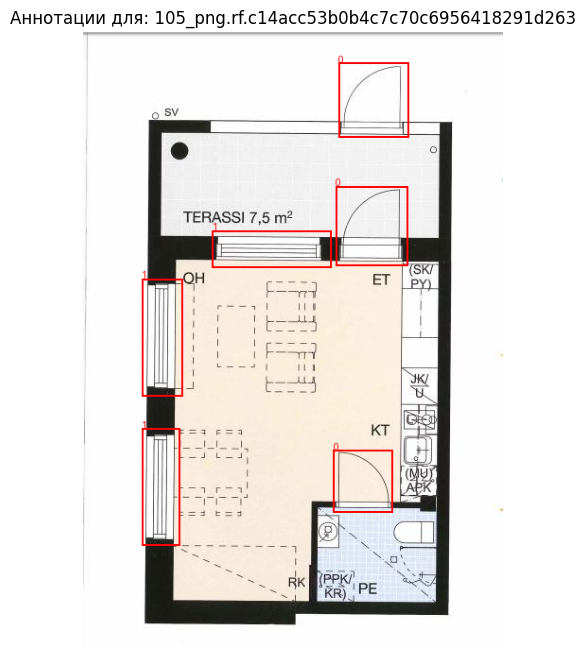

In [145]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 13)

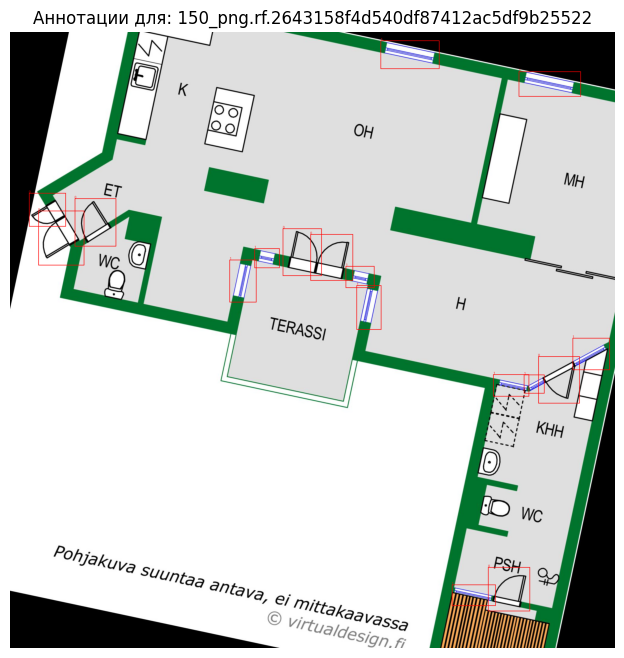

In [24]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 100)

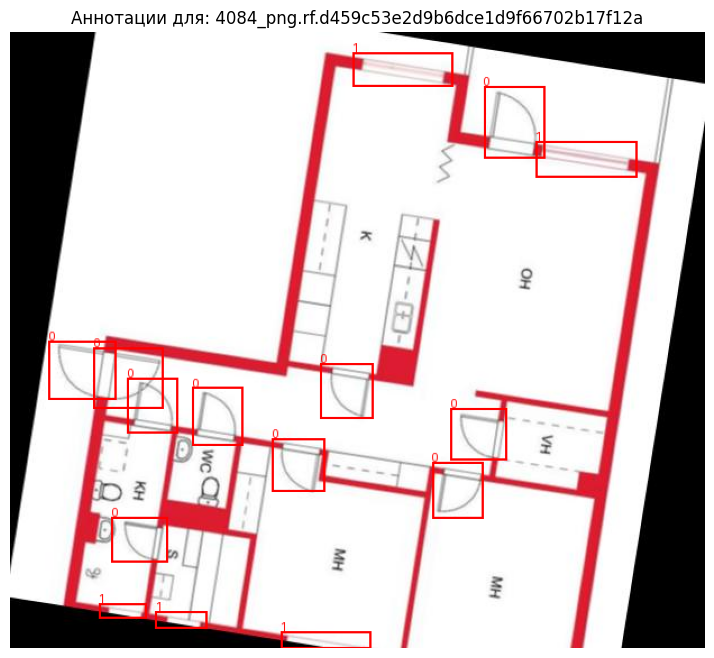

In [25]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 400)

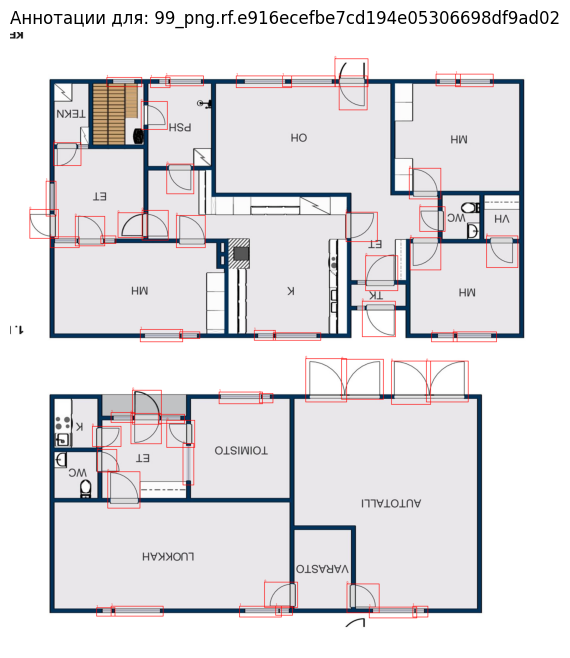

In [26]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 582)

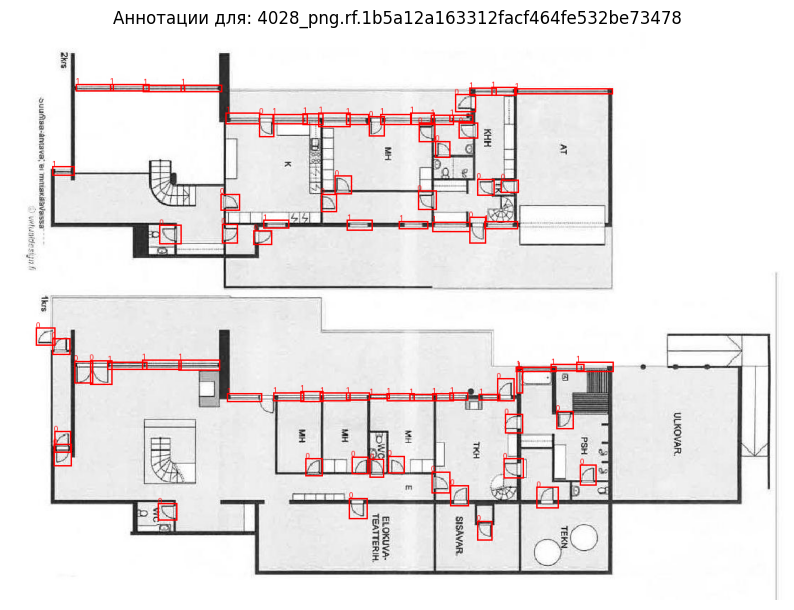

In [27]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 300)

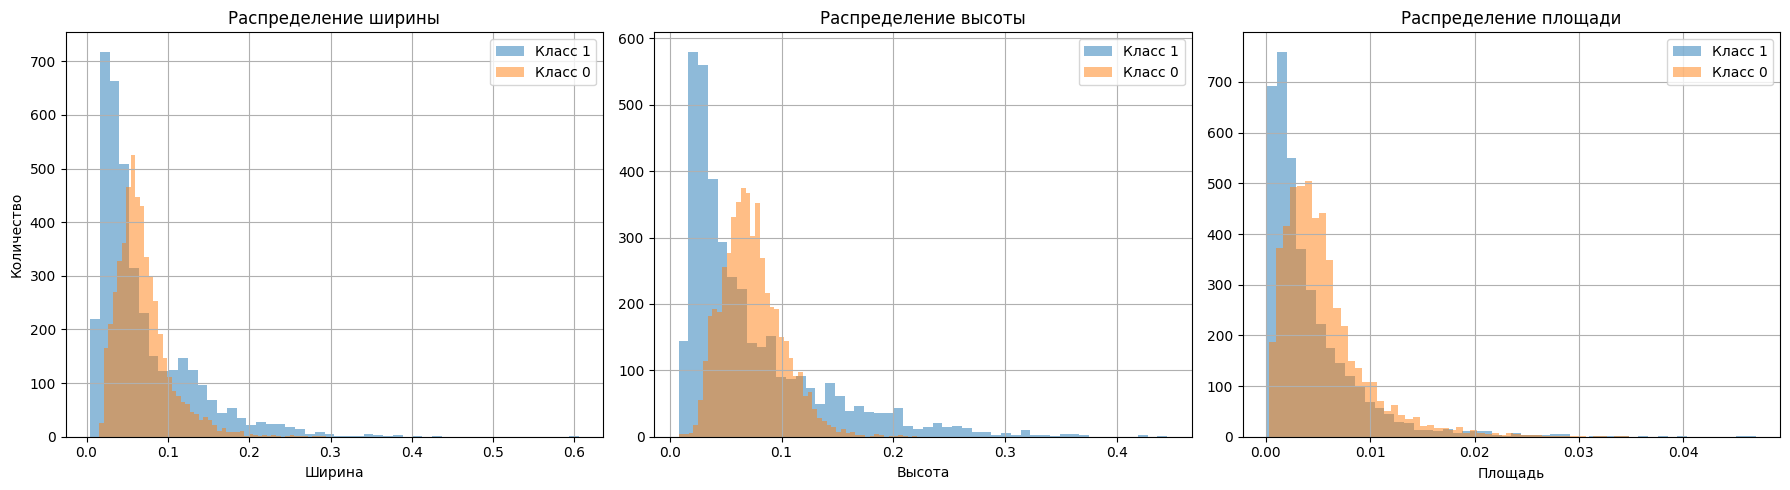

In [28]:
plot_box_distributions(train_lbl_dir)

# Обучение Yolo (определение дверей и окон)

In [29]:
# Загружаем предобученную yolo11n.pt
model = YOLO("../models/yolo11n.pt") 

In [30]:
model_name = 'yolo_door_window_model_2'

In [31]:
results = model.train(
    data="../data/train_layouts_2/data.yaml",  
    epochs=100,          
    patience=10,       
    imgsz=640,
    batch=8,
    project="../models",  
    name=model_name,   
    verbose=True,
    augment=True
)


New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/train_layouts_2/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_door_window_model_2, nbs=64, nms=False, opset=None, o

COMET ERROR: Failed to create Comet experiment, reason: ValueError('Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY ')


WARNING ⚠️ Comet installed but not initialized correctly, not logging this run. Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY 
Freezing layer 'model.23.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 151.1±55.1 MB/s, size: 46.7 KB)


train: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/train_layouts_2/train/labels... 583 images, 0 backgrounds, 0 corrupt: 100%|██████████| 583/583 [00:00<00:00, 3057.70it/s]


train: New cache created: /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/train_layouts_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 251.4±149.4 MB/s, size: 78.8 KB)


val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/train_layouts_2/valid/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 2880.70it/s]

val: New cache created: /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/train_layouts_2/valid/labels.cache
Plotting labels to ../models/yolo_door_window_model_2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to ../models/yolo_door_window_model_2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.719      2.668      1.173        162        640: 100%|██████████| 73/73 [03:13<00:00,  2.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.48s/it]

                   all         56        990      0.893       0.35      0.634      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.533      1.252      1.075        102        640: 100%|██████████| 73/73 [03:08<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.50s/it]

                   all         56        990      0.782      0.742      0.792      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      3/100         0G      1.459      1.138      1.056         83        640: 100%|██████████| 73/73 [03:08<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]

                   all         56        990      0.813      0.759      0.816      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G       1.44      1.064      1.045        139        640: 100%|██████████| 73/73 [03:09<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.53s/it]

                   all         56        990      0.826      0.804      0.844      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.386     0.9841      1.024        233        640: 100%|██████████| 73/73 [03:16<00:00,  2.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]

                   all         56        990      0.865      0.822      0.868        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.365     0.9442      1.023        221        640: 100%|██████████| 73/73 [03:17<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.49s/it]

                   all         56        990      0.901      0.846      0.895      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.374     0.9024      1.019        220        640: 100%|██████████| 73/73 [03:09<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.46s/it]

                   all         56        990      0.885      0.836      0.884      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      8/100         0G      1.328     0.8862      1.009        162        640: 100%|██████████| 73/73 [03:09<00:00,  2.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.51s/it]

                   all         56        990      0.901      0.833      0.895      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.328     0.8629      1.002        122        640: 100%|██████████| 73/73 [03:18<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

                   all         56        990      0.886      0.837       0.89       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.291     0.8388     0.9925        143        640: 100%|██████████| 73/73 [03:21<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]

                   all         56        990      0.913      0.818      0.889      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G       1.29     0.8197     0.9928        214        640: 100%|██████████| 73/73 [03:25<00:00,  2.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]

                   all         56        990      0.905      0.832      0.896       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     12/100         0G      1.381     0.8467      1.013        149        640: 100%|██████████| 73/73 [03:22<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.63s/it]

                   all         56        990      0.855      0.827      0.877      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     13/100         0G      1.292     0.8012     0.9875        188        640: 100%|██████████| 73/73 [03:21<00:00,  2.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

                   all         56        990       0.91      0.839      0.898      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.262     0.7898      0.983        173        640: 100%|██████████| 73/73 [03:20<00:00,  2.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.68s/it]

                   all         56        990       0.85      0.867      0.902      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.262     0.7605     0.9843        249        640: 100%|██████████| 73/73 [03:20<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.83s/it]

                   all         56        990      0.882      0.851      0.895       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     16/100         0G      1.243     0.7388     0.9725        161        640: 100%|██████████| 73/73 [03:23<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.59s/it]

                   all         56        990      0.877      0.876      0.914      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.236     0.7439     0.9766        157        640: 100%|██████████| 73/73 [03:18<00:00,  2.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.52s/it]

                   all         56        990      0.915      0.864      0.921      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.243      0.736     0.9717        123        640: 100%|██████████| 73/73 [03:19<00:00,  2.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]

                   all         56        990      0.926      0.841       0.91      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     19/100         0G      1.243     0.7092     0.9767        172        640: 100%|██████████| 73/73 [03:20<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.58s/it]

                   all         56        990      0.916      0.852      0.911      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     20/100         0G      1.227     0.7046     0.9719         92        640: 100%|██████████| 73/73 [03:20<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.62s/it]

                   all         56        990      0.906      0.859      0.913       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.234     0.7152     0.9675        198        640: 100%|██████████| 73/73 [03:23<00:00,  2.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.65s/it]

                   all         56        990      0.902      0.842      0.903      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.216     0.7035     0.9625        129        640: 100%|██████████| 73/73 [03:24<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

                   all         56        990      0.907      0.836      0.912      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.231     0.6991     0.9744        133        640: 100%|██████████| 73/73 [03:24<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.67s/it]

                   all         56        990      0.898      0.868      0.915      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.215     0.6869     0.9647        140        640: 100%|██████████| 73/73 [03:24<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.69s/it]

                   all         56        990       0.92       0.87      0.924      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.192     0.6771     0.9609        117        640: 100%|██████████| 73/73 [03:22<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.66s/it]

                   all         56        990      0.912      0.868      0.923      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     26/100         0G      1.166      0.659     0.9558        170        640: 100%|██████████| 73/73 [03:26<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]

                   all         56        990      0.917      0.861      0.923      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G       1.19     0.6663     0.9614        210        640: 100%|██████████| 73/73 [03:25<00:00,  2.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.84s/it]

                   all         56        990      0.923      0.868      0.918       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.186     0.6606     0.9604        214        640: 100%|██████████| 73/73 [03:28<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]

                   all         56        990       0.92      0.869       0.92      0.577

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     29/100         0G       1.22     0.6736       0.96        118        640: 100%|██████████| 73/73 [03:28<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]

                   all         56        990      0.919      0.856      0.921      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.201     0.6627     0.9564        126        640: 100%|██████████| 73/73 [03:26<00:00,  2.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.75s/it]

                   all         56        990      0.917      0.862      0.914      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G       1.18     0.6546     0.9504        177        640: 100%|██████████| 73/73 [03:28<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

                   all         56        990      0.908      0.876       0.93      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.159     0.6324     0.9454        141        640: 100%|██████████| 73/73 [03:27<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.77s/it]

                   all         56        990      0.912      0.862      0.929      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.159     0.6383     0.9473        188        640: 100%|██████████| 73/73 [03:27<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.78s/it]

                   all         56        990      0.915      0.871      0.923      0.585

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     34/100         0G      1.148     0.6325     0.9431        118        640: 100%|██████████| 73/73 [03:27<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]

                   all         56        990      0.926      0.875      0.925      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     35/100         0G      1.152     0.6366     0.9452        196        640: 100%|██████████| 73/73 [03:27<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]

                   all         56        990      0.923      0.869      0.925      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     36/100         0G      1.157     0.6267     0.9487        134        640: 100%|██████████| 73/73 [03:28<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.75s/it]

                   all         56        990      0.939      0.849      0.923      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.138     0.6208     0.9476        107        640: 100%|██████████| 73/73 [03:28<00:00,  2.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]

                   all         56        990      0.898      0.885      0.929      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.138     0.6121     0.9452        166        640: 100%|██████████| 73/73 [03:27<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]

                   all         56        990      0.896       0.89      0.932      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.128     0.6047     0.9463        317        640: 100%|██████████| 73/73 [03:28<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]

                   all         56        990      0.929      0.865      0.931      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.137      0.613      0.948        115        640: 100%|██████████| 73/73 [03:27<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.77s/it]

                   all         56        990      0.952       0.84       0.93      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.153     0.6166      0.955        163        640: 100%|██████████| 73/73 [03:33<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]

                   all         56        990      0.946      0.853      0.921      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.165     0.6076     0.9474        169        640: 100%|██████████| 73/73 [03:27<00:00,  2.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.74s/it]

                   all         56        990      0.928      0.856      0.925       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.139     0.6047     0.9393        206        640: 100%|██████████| 73/73 [03:32<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.82s/it]

                   all         56        990      0.924      0.869      0.932      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.122     0.5863     0.9427        201        640: 100%|██████████| 73/73 [03:30<00:00,  2.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.81s/it]

                   all         56        990      0.927      0.867      0.934      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.108      0.585      0.939        238        640: 100%|██████████| 73/73 [03:32<00:00,  2.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.95s/it]

                   all         56        990      0.921      0.859      0.929      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G      1.109     0.6011     0.9353        170        640: 100%|██████████| 73/73 [03:33<00:00,  2.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.78s/it]

                   all         56        990      0.909      0.885      0.928      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G       1.12     0.5948      0.934        121        640: 100%|██████████| 73/73 [03:37<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

                   all         56        990      0.912      0.864      0.924      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.111     0.5871     0.9376        144        640: 100%|██████████| 73/73 [03:37<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.74s/it]

                   all         56        990      0.925      0.874      0.926      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.115     0.5827     0.9347        114        640: 100%|██████████| 73/73 [03:34<00:00,  2.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.71s/it]

                   all         56        990      0.934      0.881      0.933      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.096     0.5775     0.9356        108        640: 100%|██████████| 73/73 [03:27<00:00,  2.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.80s/it]

                   all         56        990      0.921      0.882      0.935        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     51/100         0G      1.119     0.5865     0.9372        222        640: 100%|██████████| 73/73 [03:29<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.98s/it]

                   all         56        990      0.921      0.885      0.934      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



     52/100         0G      1.088      0.573      0.931        153        640: 100%|██████████| 73/73 [05:47<00:00,  4.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  5.00s/it]

                   all         56        990      0.918      0.876      0.934        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.085     0.5678     0.9298        179        640: 100%|██████████| 73/73 [07:32<00:00,  6.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:26<00:00,  6.52s/it]

                   all         56        990      0.909      0.893      0.933      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.096     0.5704     0.9305        179        640: 100%|██████████| 73/73 [06:35<00:00,  5.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.14s/it]

                   all         56        990      0.916      0.877      0.925      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.124     0.5764     0.9351        173        640: 100%|██████████| 73/73 [05:05<00:00,  4.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.07s/it]

                   all         56        990      0.915      0.879      0.928      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.084     0.5628     0.9293        184        640: 100%|██████████| 73/73 [04:59<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.86s/it]

                   all         56        990      0.928      0.869      0.933      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.099     0.5638     0.9353        118        640: 100%|██████████| 73/73 [05:12<00:00,  4.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.98s/it]

                   all         56        990      0.932      0.871      0.928      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.078     0.5592     0.9339        180        640: 100%|██████████| 73/73 [05:22<00:00,  4.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.11s/it]

                   all         56        990      0.937      0.886      0.933      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.076     0.5588     0.9256        199        640: 100%|██████████| 73/73 [05:31<00:00,  4.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.35s/it]

                   all         56        990      0.936      0.875      0.931      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.091      0.563      0.932         76        640: 100%|██████████| 73/73 [05:28<00:00,  4.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:16<00:00,  4.17s/it]

                   all         56        990      0.919      0.878      0.925      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      1.087     0.5595     0.9241        217        640: 100%|██████████| 73/73 [05:17<00:00,  4.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.87s/it]

                   all         56        990      0.934       0.88      0.928      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.071     0.5483     0.9234         93        640: 100%|██████████| 73/73 [04:58<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:15<00:00,  3.80s/it]

                   all         56        990      0.928      0.891      0.932      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G       1.08     0.5466     0.9227        220        640: 100%|██████████| 73/73 [04:52<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.64s/it]

                   all         56        990      0.907      0.894      0.932      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.067     0.5531     0.9201        200        640: 100%|██████████| 73/73 [04:51<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:17<00:00,  4.27s/it]

                   all         56        990      0.933      0.877       0.93      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.059     0.5449     0.9182        214        640: 100%|██████████| 73/73 [04:48<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.67s/it]

                   all         56        990      0.913      0.898      0.937      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.071     0.5435     0.9266        119        640: 100%|██████████| 73/73 [04:41<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.60s/it]

                   all         56        990      0.926      0.875      0.929      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.062     0.5406     0.9204        127        640: 100%|██████████| 73/73 [04:55<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.67s/it]

                   all         56        990      0.952       0.86      0.932      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.049     0.5337     0.9198        113        640: 100%|██████████| 73/73 [06:08<00:00,  5.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.89s/it]

                   all         56        990      0.944      0.871      0.931      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.049     0.5335     0.9168        136        640: 100%|██████████| 73/73 [06:57<00:00,  5.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:22<00:00,  5.68s/it]

                   all         56        990      0.937      0.864      0.928      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.054     0.5314     0.9228        155        640: 100%|██████████| 73/73 [08:20<00:00,  6.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:14<00:00,  3.68s/it]

                   all         56        990      0.943      0.872      0.925      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.035     0.5286     0.9127        127        640: 100%|██████████| 73/73 [04:44<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.36s/it]

                   all         56        990      0.946      0.868      0.931      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.051     0.5344     0.9176        228        640: 100%|██████████| 73/73 [05:07<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:12<00:00,  3.17s/it]

                   all         56        990      0.934      0.863      0.924       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G       1.04      0.528     0.9189        290        640: 100%|██████████| 73/73 [03:57<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.79s/it]

                   all         56        990      0.941      0.871      0.927      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.037     0.5197     0.9172        166        640: 100%|██████████| 73/73 [04:26<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:19<00:00,  4.86s/it]

                   all         56        990      0.942      0.878       0.93      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.027     0.5173     0.9184        114        640: 100%|██████████| 73/73 [05:20<00:00,  4.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:11<00:00,  2.89s/it]

                   all         56        990      0.933       0.87       0.93      0.607
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 65, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



75 epochs completed in 5.348 hours.
Optimizer stripped from ../models/yolo_door_window_model_2/weights/last.pt, 5.5MB
Optimizer stripped from ../models/yolo_door_window_model_2/weights/best.pt, 5.5MB

Validating ../models/yolo_door_window_model_2/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:25<00:00,  6.26s/it]


                   all         56        990      0.932      0.863       0.93      0.602
                  door         56        527      0.977      0.947      0.972      0.702
                window         56        463      0.887       0.78      0.889      0.501
Speed: 1.5ms preprocess, 417.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to ../models/yolo_door_window_model_2


## Оценка модели на валидационной выборке

In [46]:
model = YOLO("../models/yolo_door_window_model_2/weights/best.pt")

metrics = model.val(
    data="../data/train_layouts_2/data.yaml",
    imgsz=640,
    split='val',
    conf=0.61, 
    project="../models/" + model_name,
    name="validation",
    exist_ok=True 
)

Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 116.4±61.5 MB/s, size: 32.7 KB)


val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/train_layouts_2/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.73s/it]


                   all         56        990      0.971      0.814      0.896       0.64
                  door         56        527      0.986      0.928       0.96      0.739
                window         56        463      0.956        0.7      0.831      0.541
Speed: 1.7ms preprocess, 170.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to ../models/yolo_door_window_model_2/validation


## Оценка на тестовой выборке

In [48]:
# Выбираем тестовое изображение
test_image = "../data/train_layouts_2/test/images"

results = model.predict(
    source=test_image, 
    imgsz=640,
    save=True,                        # сохранить предсказания
    save_txt=True,          # сохранить координаты bbox в .txt
    project="../models/"+model_name,
    name="test",          
    exist_ok=True,              # перезаписать если уже есть
    conf=0.61
)


image 1/28 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/train_layouts_2/test/images/101_png.rf.2831354ce0c405757c14fac9a18bb7a5.jpg: 352x640 8 doors, 6 windows, 77.6ms
image 2/28 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/train_layouts_2/test/images/106_png.rf.9d0b2ae5b9503a296dde4cf843629516.jpg: 640x480 9 doors, 3 windows, 61.0ms
image 3/28 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/train_layouts_2/test/images/111_png.rf.a278820f10dd56a09c28519693961512.jpg: 640x288 4 doors, 42.3ms
image 4/28 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/train_layouts_2/test/images/112_png.rf.312fefb69d0acf1f79f40c634db36f3f.jpg: 640x480 10 doors, 5 windows, 61.7ms
image 5/28 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/train_layouts_2/test/images/124_png.rf.5809632b072782056a327731d84710a1.jpg: 608x640 1

## Оценка на данных заказчика

In [147]:
# Выбираем тестовое изображение
test_image = "../data/customer_layout_for_train"
model = YOLO("../models/yolo_door_window_model_2/weights/best.pt")
results = model.val(
    source=test_image, 
    imgsz=640,
    save=True,                        # сохранить предсказания
    save_txt=True,          # сохранить координаты bbox в .txt
    project="../models/yolo_door_window_model_2/val",
    name="customer_layouts",          
    exist_ok=True,              # перезаписать если уже есть
    conf=0.61
)

Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 159.8±162.1 MB/s, size: 57.9 KB)


val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/train_layouts_2/valid/labels.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/4 [00:00<?, ?it/s]0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


                   all         56        990      0.971      0.814      0.896       0.64
                  door         56        527      0.986      0.928       0.96      0.739
                window         56        463      0.956        0.7      0.831      0.541
Speed: 1.3ms preprocess, 159.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to ../models/yolo_door_window_model_2/val/customer_layouts


## Получение координат объектов (двери и окна)

In [68]:
def load_yolo_bboxes(label_path, class_names=['door', 'window']):
    """
    Загружает bbox из YOLO-формата txt-файла.
    Возвращает список кортежей: (class_name, x_center_norm, y_center_norm, width_norm, height_norm)
    
    :param label_path: путь к txt-файлу с аннотациями
    :param class_names: список названий классов по индексам
    :return: список кортежей с информацией о bbox
    """
    bboxes = []
    if not os.path.exists(label_path):
        return bboxes

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            
            class_id, x_center, y_center, width, height = map(float, parts)
            class_id = int(class_id)
            
            # Определяем название класса
            if 0 <= class_id < len(class_names):
                class_name = class_names[class_id]
            else:
                class_name = f"unknown_class_{class_id}"
            
            bboxes.append((class_name, x_center, y_center, width, height))

    return bboxes


def get_supported_image_extensions():
    """
    Возвращает список поддерживаемых расширений изображений.
    """
    return ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']


def find_image_files(images_dir):
    """
    Находит все файлы изображений в директории с автоматическим определением расширения.
    
    :param images_dir: путь к папке с изображениями
    :return: список путей к файлам изображений
    """
    image_paths = []
    extensions = get_supported_image_extensions()
    
    for ext in extensions:
        # Поиск файлов с текущим расширением (нечувствительно к регистру)
        pattern = os.path.join(images_dir, f'*{ext}')
        image_paths.extend(glob.glob(pattern))
        # Также ищем в верхнем регистре
        pattern = os.path.join(images_dir, f'*{ext.upper()}')
        image_paths.extend(glob.glob(pattern))
    
    return image_paths


def convert_all_bboxes_in_folder(images_dir, labels_dir, class_names=['door', 'window']):
    """
    Обрабатывает все изображения в папке и извлекает информацию о bbox.

    :param images_dir: путь к папке с изображениями
    :param labels_dir: путь к папке с txt-файлами YOLO
    :param class_names: список названий классов
    :return: словарь {image_name: [(class_name, x_px, y_px), ...]}
    """
    bbox_info_by_image = {}

    # Автоматическое определение файлов изображений
    image_paths = find_image_files(images_dir)
    
    if not image_paths:
        print(f"⚠️ В директории {images_dir} не найдено изображений с поддерживаемыми расширениями")
        print(f"Поддерживаемые расширения: {', '.join(get_supported_image_extensions())}")
        return bbox_info_by_image

    for image_path in image_paths:
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        label_path = os.path.join(labels_dir, image_name + '.txt')

        image = cv2.imread(image_path)
        if image is None:
            print(f"⚠️ Пропущено (не удалось загрузить): {image_path}")
            continue

        height, width = image.shape[:2]

        bboxes = load_yolo_bboxes(label_path, class_names)
        
        # Преобразуем нормализованные координаты в пиксели и сохраняем класс
        bbox_info = []
        for class_name, x, y, w, h in bboxes:
            x_px = int(x * width)
            y_px = int(y * height)
            bbox_info.append((class_name, x_px, y_px))

        bbox_info_by_image[image_name] = bbox_info
        
        # Выводим информацию о найденных объектах
        if bbox_info:
            print(f"📷 {image_name}: найдено {len(bbox_info)} объектов")
            for class_name, x_px, y_px in bbox_info:
                print(f"   - {class_name}: центр ({x_px}, {y_px})")
        else:
            print(f"📷 {image_name}: объекты не найдены")

    return bbox_info_by_image



In [6]:
images_directory = '../models/yolo_door_window_model_2/customer_layouts'
labels_directory = '../models/yolo_door_window_model_2/customer_layouts/labels'

# Можно указать свои классы
custom_classes = ['door', 'window']

result = convert_all_bboxes_in_folder(images_directory, labels_directory, custom_classes)

# Вывод результатов
for image_name, bbox_list in result.items():
    print(f"\nИзображение: {image_name}")
    for class_name, x, y in bbox_list:
        print(f"  {class_name}: ({x}, {y})")

📷 1plan: найдено 9 объектов
   - window: центр (1036, 279)
   - window: центр (939, 778)
   - window: центр (677, 224)
   - window: центр (1093, 337)
   - window: центр (871, 278)
   - window: центр (1064, 602)
   - window: центр (680, 831)
   - window: центр (585, 524)
   - window: центр (586, 395)
📷 qmLZuCZUs4dqPSnE64fBwa11QDZWbp1qLEai4Sch: объекты не найдены
📷 4c91f13dedd67c1154fece6c33d7185f8e76f83a: найдено 4 объектов
   - door: центр (393, 564)
   - door: центр (378, 647)
   - door: центр (402, 301)
   - door: центр (317, 201)
📷 f601974ac68db3e94f1d08220406cbdfa3418857: найдено 6 объектов
   - door: центр (362, 652)
   - door: центр (399, 297)
   - door: центр (389, 568)
   - door: центр (316, 176)
   - window: центр (430, 69)
   - window: центр (485, 70)
📷 5871: найдено 6 объектов
   - door: центр (57, 101)
   - door: центр (106, 152)
   - door: центр (58, 153)
   - door: центр (57, 67)
   - door: центр (341, 50)
   - door: центр (386, 37)
📷 Unit M: найдено 2 объектов
   - windo

# Загрузка датасета (мебель)

In [9]:
data_path ="../data/furniture"
train = eda_df(data_path)

Кол-во изображений: 1134
Кол-во файлов аннотаций: 1134
---
             width       height
count  1134.000000  1134.000000
mean   1356.812169  1256.259259
std     353.446182   315.628791
min     719.000000   603.000000
25%    1104.000000  1058.000000
50%    1285.500000  1206.500000
75%    1545.000000  1420.000000
max    2048.000000  2048.000000
---

Распределение объектов по классам:

Класс 2: 1733 объектов
Класс 3: 940 объектов
Класс 4: 975 объектов
Класс 5: 1107 объектов
Класс 6: 241 объектов
Класс 7: 1167 объектов
Класс 8: 1041 объектов
---
Классы: ['door', 'window', 'bed', 'dining_table', 'toilet', 'sofa', 'round_table', 'sink', 'tub']


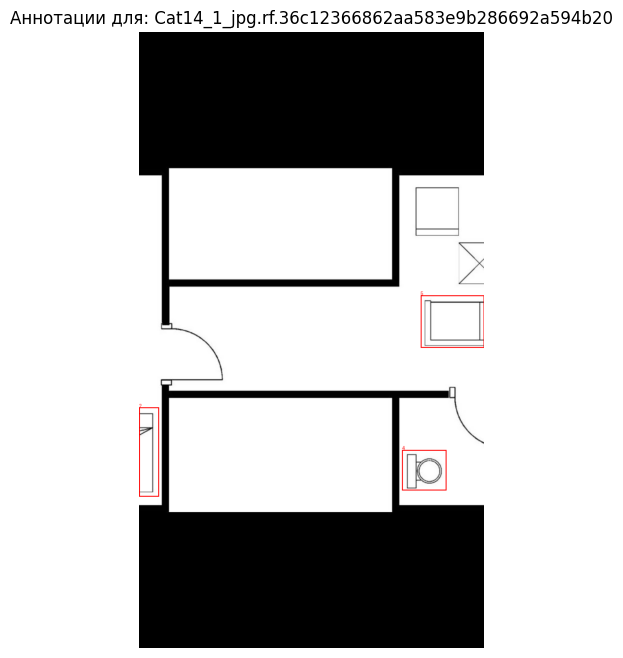

In [10]:
train_img_dir, train_lbl_dir, class_names = train[0]
show_image_labels(train_img_dir, train_lbl_dir, class_names, 100)

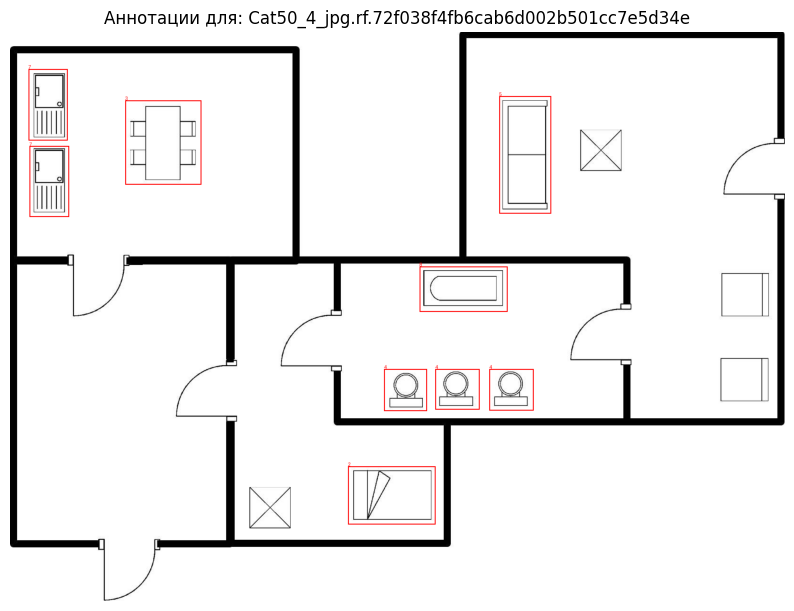

In [11]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 1000)

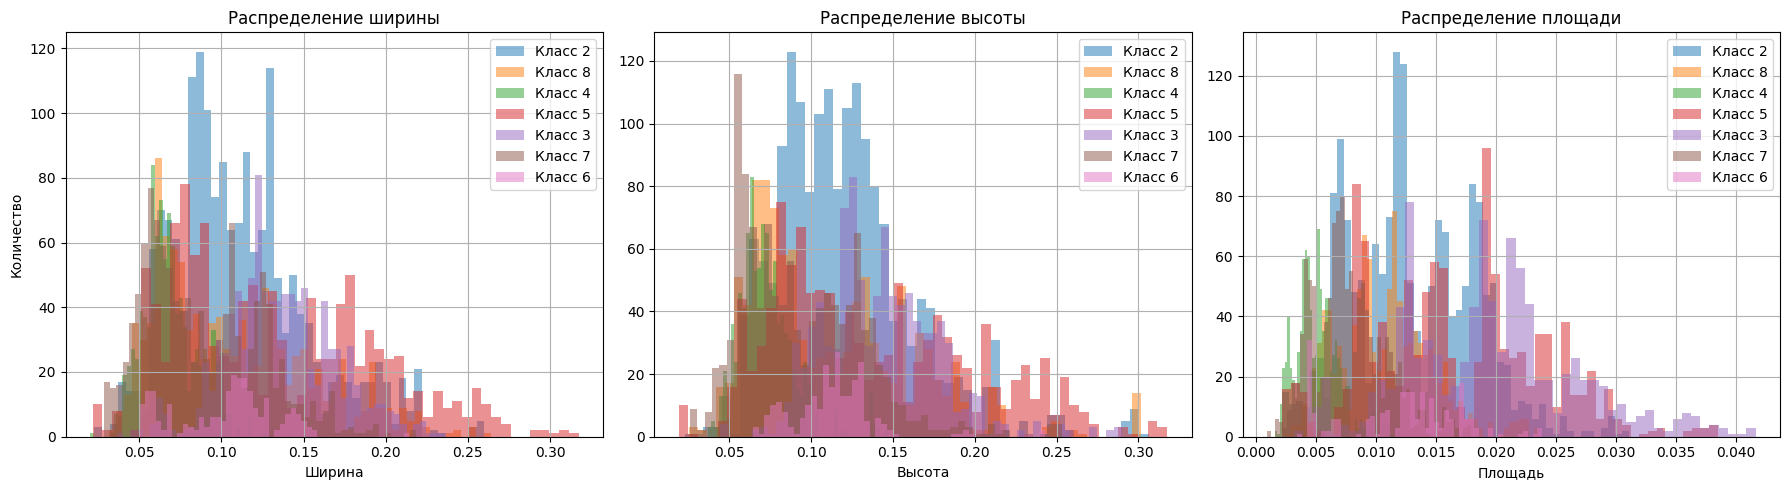

In [12]:
plot_box_distributions(train_lbl_dir)

# Обучение модели для определения предметов мебели на плане (Для определения назначения помещения)

In [14]:
# Загружаем предобученную 
model_step2 = YOLO("../models/xrplace_yolo_door_window/weights/best.pt") 

In [25]:
model_name_step2 = 'xrplace_furniture'

In [16]:
results_step2 = model_step2 .train(
    data="../data/furniture/data.yaml",  
    epochs=45,          # Максимальное число эпох (обучение может остановиться раньше)
    patience=10,        # Ранняя остановка, если нет улучшений 10 эпох подряд
    imgsz=640,
    batch=8,
    project="../models",  
    name=model_name_step2,   
    verbose=True,
    augment=True
)

New https://pypi.org/project/ultralytics/8.3.161 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data/furniture/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=45, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=../models/xrplace_yolo_door_window/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=xrplace_furniture2, nbs=64, nms=Fal

COMET ERROR: Failed to create Comet experiment, reason: ValueError('Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY ')


WARNING ⚠️ Comet installed but not initialized correctly, not logging this run. Comet.ml requires an API key. Please provide as the first argument to Experiment(api_key) or as an environment variable named COMET_API_KEY 
Freezing layer 'model.23.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 181.3±83.1 MB/s, size: 84.6 KB)


train: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/furniture/train/labels... 1134 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1134/1134 [00:00<00:00, 3443.15it/s]

train: New cache created: /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/furniture/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 219.1±42.4 MB/s, size: 89.0 KB)



val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/furniture/valid/labels... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 3274.28it/s]

val: New cache created: /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/furniture/valid/labels.cache
Plotting labels to ../models/xrplace_furniture2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000769, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to ../models/xrplace_furniture2
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45         0G     0.9454      3.215     0.9867         62        640: 100%|██████████| 142/142 [07:31<00:00,  3.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

                   all         75        546      0.671      0.648      0.596       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45         0G     0.7505      1.394     0.9067         49        640: 100%|██████████| 142/142 [06:47<00:00,  2.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

                   all         75        546       0.77      0.908      0.854      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45         0G     0.7025      1.051     0.8844         55        640: 100%|██████████| 142/142 [06:33<00:00,  2.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

                   all         75        546      0.839      0.961      0.886      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/45         0G     0.6975     0.9235     0.8836         58        640: 100%|██████████| 142/142 [06:31<00:00,  2.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.58s/it]

                   all         75        546      0.822      0.975      0.884      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45         0G     0.6761     0.8563     0.8798         67        640: 100%|██████████| 142/142 [06:11<00:00,  2.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

                   all         75        546      0.831      0.979      0.911      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/45         0G     0.6566     0.8125     0.8745         64        640: 100%|██████████| 142/142 [06:37<00:00,  2.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

                   all         75        546      0.836      0.971      0.922      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45         0G     0.6436     0.7751     0.8757         42        640: 100%|██████████| 142/142 [06:24<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

                   all         75        546      0.864      0.957      0.933       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/45         0G     0.6422      0.786     0.8696         53        640: 100%|██████████| 142/142 [06:24<00:00,  2.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]

                   all         75        546      0.835      0.981      0.922        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45         0G     0.6453     0.7389     0.8702         82        640: 100%|██████████| 142/142 [08:00<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.88s/it]

                   all         75        546      0.846      0.967      0.937      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45         0G     0.6261     0.7094     0.8677         64        640: 100%|██████████| 142/142 [08:37<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.86s/it]

                   all         75        546      0.863      0.964      0.924      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45         0G     0.6371     0.7049     0.8648         76        640: 100%|██████████| 142/142 [08:58<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:20<00:00,  4.02s/it]

                   all         75        546      0.874      0.961      0.941      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/45         0G     0.6175      0.699     0.8663         31        640: 100%|██████████| 142/142 [09:04<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

                   all         75        546      0.895      0.949      0.947      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/45         0G     0.6291     0.6758     0.8683         84        640: 100%|██████████| 142/142 [08:13<00:00,  3.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

                   all         75        546      0.914      0.953      0.964      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/45         0G     0.6203     0.6564     0.8628         49        640: 100%|██████████| 142/142 [08:19<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:19<00:00,  3.88s/it]

                   all         75        546      0.935      0.934       0.95      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/45         0G      0.623     0.6293     0.8622         50        640: 100%|██████████| 142/142 [08:33<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

                   all         75        546      0.931      0.932      0.968      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/45         0G     0.6155     0.6082     0.8638         74        640: 100%|██████████| 142/142 [07:07<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.46s/it]

                   all         75        546      0.915      0.963      0.961      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/45         0G     0.6097     0.5982      0.861         61        640: 100%|██████████| 142/142 [05:47<00:00,  2.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.58s/it]

                   all         75        546      0.904      0.966      0.965      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/45         0G     0.6104     0.5857     0.8637         59        640: 100%|██████████| 142/142 [05:52<00:00,  2.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]

                   all         75        546      0.907      0.981      0.971      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/45         0G     0.5989     0.5723     0.8612         41        640: 100%|██████████| 142/142 [05:58<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

                   all         75        546       0.91      0.974      0.966      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/45         0G     0.5936      0.574     0.8581         57        640: 100%|██████████| 142/142 [06:04<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]

                   all         75        546      0.925      0.976      0.954      0.791

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/45         0G     0.5991     0.5777     0.8605         72        640: 100%|██████████| 142/142 [06:04<00:00,  2.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

                   all         75        546      0.942      0.957       0.98      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/45         0G     0.5978     0.5682     0.8598         42        640: 100%|██████████| 142/142 [06:03<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.73s/it]

                   all         75        546      0.956      0.983      0.977      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/45         0G     0.5974     0.5608     0.8591         43        640: 100%|██████████| 142/142 [06:00<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.70s/it]

                   all         75        546      0.917      0.969      0.966      0.842

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/45         0G     0.5817     0.5305     0.8546         66        640: 100%|██████████| 142/142 [05:59<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]

                   all         75        546      0.945      0.981      0.976       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/45         0G     0.5845     0.5389     0.8567         86        640: 100%|██████████| 142/142 [06:00<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

                   all         75        546      0.923      0.971      0.975      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/45         0G     0.5859     0.5357     0.8552         60        640: 100%|██████████| 142/142 [05:57<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]

                   all         75        546      0.969      0.976      0.978      0.868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/45         0G     0.5806     0.5158     0.8553         52        640: 100%|██████████| 142/142 [06:01<00:00,  2.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]

                   all         75        546      0.971      0.971       0.98      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/45         0G     0.5845     0.5213      0.854         25        640: 100%|██████████| 142/142 [06:01<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.67s/it]

                   all         75        546       0.94       0.97      0.969      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/45         0G     0.5781     0.5017     0.8551         72        640: 100%|██████████| 142/142 [06:00<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.69s/it]

                   all         75        546      0.928      0.968      0.976       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/45         0G      0.593     0.5146       0.86        108        640: 100%|██████████| 142/142 [05:59<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.71s/it]

                   all         75        546      0.986      0.973      0.979      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/45         0G     0.5732     0.4777     0.8527         38        640: 100%|██████████| 142/142 [05:57<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]

                   all         75        546      0.975       0.98      0.979      0.871
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 21, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

31 epochs completed in 3.628 hours.


Optimizer stripped from ../models/xrplace_furniture2/weights/last.pt, 5.5MB
Optimizer stripped from ../models/xrplace_furniture2/weights/best.pt, 5.5MB

Validating ../models/xrplace_furniture2/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,583,907 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:30<00:00,  6.10s/it]


                   all         75        546      0.963      0.952      0.982      0.858
                   bed         59        120       0.91          1      0.983      0.891
          dining_table         59         75      0.992       0.96      0.976      0.888
                toilet         51         61      0.972      0.984      0.994      0.794
                  sofa         57        105      0.958      0.867      0.952      0.844
           round_table         12         15      0.967      0.867      0.987      0.838
                  sink         74         97      0.976          1      0.994      0.873
                   tub         55         73      0.968      0.986      0.988      0.875
Speed: 1.3ms preprocess, 387.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to ../models/xrplace_furniture2


In [21]:
best_model_2 = YOLO("../models/xrplace_furniture/weights/best.pt")

metrics = best_model_2.val(
    data="../data/furniture/data.yaml",
    imgsz=640,
    split='val',
    project="../models/" + model_name_step2,     # Папка, куда сохранить
    name="validation"        # Название подпапки внутри project
)

print(metrics)

Ultralytics 8.3.158 🚀 Python-3.11.9 torch-2.7.1 CPU (Apple M1)
YOLO11n summary (fused): 100 layers, 2,583,907 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 179.2±49.1 MB/s, size: 69.8 KB)


val: Scanning /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/data/furniture/valid/labels.cache... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:12<00:00,  2.60s/it]


                   all         75        546      0.942      0.956      0.981      0.874
                   bed         59        120      0.902      0.993      0.973      0.899
          dining_table         59         75       0.99       0.96      0.976      0.918
                toilet         51         61      0.926      0.984      0.993      0.811
                  sofa         57        105      0.955      0.876      0.962      0.867
           round_table         12         15      0.925      0.933      0.975      0.844
                  sink         74         97      0.961       0.99      0.995      0.892
                   tub         55         73      0.938      0.959       0.99      0.889
Speed: 1.6ms preprocess, 153.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to ../models/xrplace_furniture/validation
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([2, 3, 4, 5, 6, 7, 8])
box: ultralytics.utils.metrics.Metric obj

In [22]:
# Выбираем тестовое изображение
test_image = "../data/furniture/test/images"

results = best_model_2.predict(
    source=test_image, 
    imgsz=640,
    save=True,                        # сохранить предсказания
    save_txt=True,          # сохранить координаты bbox в .txt
    project="../models/"+model_name_step2,
    name="test",          
    exist_ok=True                    # перезаписать если уже есть
)


image 1/51 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/furniture/test/images/Cat10_1_jpg.rf.b8f2870b3ef7db9018040a7e0d3cfca6.jpg: 416x640 2 beds, 1 dining_table, 1 toilet, 1 sofa, 1 sink, 1 tub, 62.0ms
image 2/51 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/furniture/test/images/Cat10_2_jpg.rf.b4aaabc210d6cc8acc3fe1dd685c33da.jpg: 416x640 2 beds, 1 dining_table, 1 toilet, 1 sofa, 52.8ms
image 3/51 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/furniture/test/images/Cat12_3_jpg.rf.98f046ef1fc69f63486b7c8598c1e437.jpg: 640x416 2 beds, 1 dining_table, 1 toilet, 1 sofa, 1 sink, 1 tub, 56.1ms
image 4/51 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/furniture/test/images/Cat13_4_jpg.rf.8f951a8b0f667436499cbf6ecb51ab13.jpg: 448x640 2 beds, 1 toilet, 1 sofa, 1 tub, 48.4ms
image 5/51 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_det

# Дальше можно не смотреть

# Получение координат углов помещения 

In [45]:
data_path ="../data/customer_layout_for_train"
ds = eda_df(data_path)

Кол-во изображений: 87
Кол-во файлов аннотаций: 87
---
             width       height
count    87.000000    87.000000
mean    932.206897   858.068966
std     405.815577   463.048714
min     242.000000   223.000000
25%     720.000000   531.000000
50%     860.000000   720.000000
75%    1268.000000  1255.000000
max    1680.000000  2048.000000
---

Распределение объектов по классам:

Класс 0: 363 объектов
Класс 1: 205 объектов
---
Классы: ['door', 'window']


In [47]:
train_img_dir, train_lbl_dir, class_names = ds[0]

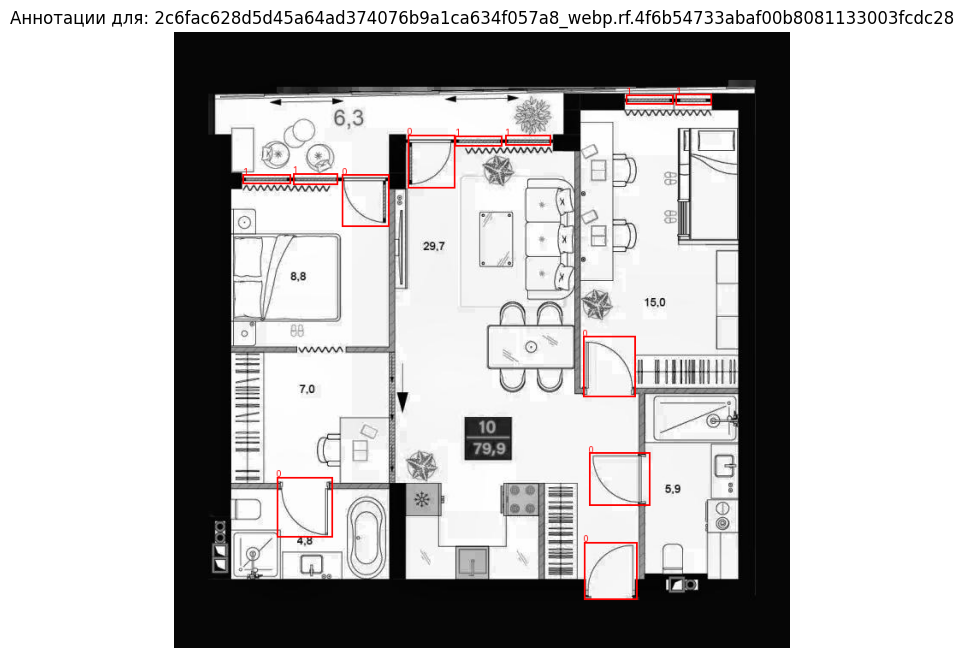

In [122]:
show_image_labels(train_img_dir, train_lbl_dir, class_names, 7)

In [41]:
model_path = "../models/room_coordinates_model/room_coordinates_model.pt"
model_room_coord = YOLO(model_path)

In [42]:
def fit_circle(points):
    """
    Простая аппроксимация дуги: используется cv2.minEnclosingCircle,
    чтобы получить центр и радиус, охватывающие данный набор точек.

    Параметры:
        points (np.ndarray): массив точек (Nx2)

    Возвращает:
        center (tuple): (x, y) - координаты центра
        radius (float): радиус окружности
    """
    pts = np.array(points, dtype=np.float32)
    center, radius = cv2.minEnclosingCircle(pts)
    return tuple(center), radius

In [43]:
def simplify_polygon(points, rdp_tol=0.02, curvature_threshold=15, arc_resolution=20):
    """
    Оптимизирует набор точек полигона:
      1. Упрощает исходный полигон с помощью алгоритма RDP.
      2. Проходит по упрощённому контуру и определяет "резкие" углы,
         оставляя их как ключевые вершины.
      3. Для участков с плавным изменением направления (почти прямая линия)
         выполняется аппроксимация дугой окружности, которая затем равномерно
         интерполируется заданным числом точек.

    Параметры:
        points (np.ndarray): Исходный набор точек полигона (Nx2).
        rdp_tol (float): Допуск для алгоритма RDP (относительно периметра).
        curvature_threshold (float): Порог отклонения угла от 180° (в градусах).
            Если угол между соседними сегментами близок к 180° (разница ≤ порога),
            участок считается гладким и аппроксимируется дугой.
        arc_resolution (int): Количество точек для интерполяции дуги.

    Возвращает:
        np.ndarray: Оптимизированный массив точек полигона.
    """
    # Шаг 1. Упрощаем полигон с помощью RDP
    epsilon = rdp_tol * cv2.arcLength(points, True)
    simplified = cv2.approxPolyDP(points, epsilon=epsilon, closed=True)
    simplified = simplified.reshape(-1, 2)

    optimized = []
    n = len(simplified)
    i = 0
    while i < n:
        # Определяем предыдущую и следующую точки (с учетом замыкания контура)
        prev = simplified[i - 1]
        curr = simplified[i]
        next = simplified[(i + 1) % n]

        # Вычисляем угол между векторами (curr - prev) и (next - curr)
        v1 = curr - prev
        v2 = next - curr
        norm_v1 = np.linalg.norm(v1)
        norm_v2 = np.linalg.norm(v2)
        if norm_v1 < 1e-6 or norm_v2 < 1e-6:
            angle_deg = 0
        else:
            cos_angle = np.clip(np.dot(v1, v2) / (norm_v1 * norm_v2), -1.0, 1.0)
            angle_deg = np.degrees(np.arccos(cos_angle))

        # Если угол отличается от 180° на более чем порог, считаем вершину "резкой"
        if abs(angle_deg - 180) > curvature_threshold:
            optimized.append(curr.tolist())
            i += 1
        else:
            # Группируем последовательные точки, где угол близок к 180° (гладкий участок)
            arc_points = [curr]
            j = i + 1
            while j < n:
                prev_j = simplified[j - 1]
                curr_j = simplified[j]
                next_j = simplified[(j + 1) % n]
                v1_j = curr_j - prev_j
                v2_j = next_j - curr_j
                norm_v1_j = np.linalg.norm(v1_j)
                norm_v2_j = np.linalg.norm(v2_j)
                if norm_v1_j < 1e-6 or norm_v2_j < 1e-6:
                    angle_j = 0
                else:
                    cos_angle_j = np.clip(np.dot(v1_j, v2_j) / (norm_v1_j * norm_v2_j), -1.0, 1.0)
                    angle_j = np.degrees(np.arccos(cos_angle_j))
                if abs(angle_j - 180) > curvature_threshold:
                    break
                arc_points.append(curr_j)
                j += 1

            # Если группа достаточно длинная, аппроксимируем дугу
            if len(arc_points) >= 3:
                center, radius = fit_circle(arc_points)
                # Определяем начальный и конечный углы для дуги
                start_angle = np.arctan2(arc_points[0][1] - center[1], arc_points[0][0] - center[0])
                end_angle = np.arctan2(arc_points[-1][1] - center[1], arc_points[-1][0] - center[0])
                # Корректируем диапазон углов
                if end_angle < start_angle:
                    end_angle += 2 * np.pi
                # Интерполируем дугу
                interp_angles = np.linspace(start_angle, end_angle, arc_resolution)
                arc_interp = [[int(center[0] + radius * np.cos(a)),
                               int(center[1] + radius * np.sin(a))] for a in interp_angles]
                optimized.extend(arc_interp)
            else:
                # Если группа слишком короткая, просто добавляем точки
                optimized.extend([pt.tolist() for pt in arc_points])
            i = j

    return np.array(optimized, dtype=np.int32)
model_path = "../models/room_coordinates_model/room_coordinates_model.pt"

model_room_coord = YOLO(model_path)

In [36]:
def process_image(image):
    """
    Обрабатывает изображение:
    - Выполняет предсказание модели YOLO для детекции комнат.
    - Рисует упрощённые полигоны (с углами) для объектов класса 'room' (id = 2).
    - Формирует список словарей с информацией о комнатах и их координатах.
    
    Параметры:
        image (np.ndarray): Исходное изображение.
    
    Возвращает:
        annotated_img (np.ndarray): Изображение с нанесёнными аннотациями.
        rooms_data (list): Список словарей с информацией о комнатах и их координатах.
                          Если комнат нет, возвращается строка с сообщением.
    """
    pred_results = list(model_room_coord.predict(source=image, imgsz=640))
    if len(pred_results) == 0:
        return image, "Ошибка: предсказания не получены."

    pred = pred_results[0]
    if pred.masks is None or pred.boxes is None:
        return image, "На изображении объекты не обнаружены."

    # Получаем оригинальное изображение и конвертируем его в RGB
    orig_img = pred.orig_img
    if orig_img.shape[2] == 3:
        original_rgb = cv2.cvtColor(orig_img.copy(), cv2.COLOR_BGR2RGB)
    else:
        original_rgb = orig_img.copy()

    annotated_img = original_rgb.copy()
    polygons = pred.masks.xy
    class_ids = pred.boxes.cls.cpu().numpy()

    coordinates_list = []
    for idx, polygon in enumerate(polygons):
        class_id = int(class_ids[idx])
        if class_id == 2:  # Проверяем, что это комната (class_id = 2)
            poly_np = np.array(polygon, dtype=np.float32)
            simplified_poly = simplify_polygon(poly_np, rdp_tol=0.005, curvature_threshold=15, arc_resolution=20)
            coordinates_list.append({
                "object": idx + 1,
                "class": class_id,
                "coordinates": [(float(pt[0]), float(pt[1])) for pt in simplified_poly]
            })
            # Рисуем полигон и точки на изображении
            cv2.polylines(annotated_img, [simplified_poly.astype(np.int32)], isClosed=True, color=(0, 255, 0), thickness=2)
            for point in simplified_poly:
                cv2.circle(annotated_img, (int(point[0]), int(point[1])), 3, (255, 0, 0), -1)

    # Формируем список комнат с координатами
    if coordinates_list:
        rooms_data = []
        for item in coordinates_list:
            room_info = {
                'room': item['object'],
                'coordinates': [(round(coord[0], 2), round(coord[1], 2)) for coord in item['coordinates']]
            }
            rooms_data.append(room_info)
        return annotated_img, rooms_data
    else:
        return annotated_img, "На изображении не обнаружены комнаты."

In [123]:
# Загружаем изображение
image_path = "../data/customer_layouts/2c6fac628d5d45a64ad374076b9a1ca634f057a8.webp"
image_cv = cv2.imread(image_path)  # по умолчанию BGR формат

# Если необходимо преобразовать из BGR в RGB 
# (OpenCV по умолчанию загружает как BGR)
image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

In [124]:
room_coord = process_image(image=image_cv)
room_coord[1]


0: 640x640 9 rooms, 528.5ms
Speed: 31.9ms preprocess, 528.5ms inference, 40.0ms postprocess per image at shape (1, 3, 640, 640)


[{'room': 1,
  'coordinates': [(474.0, 87.0),
   (474.0, 419.0),
   (594.0, 414.0),
   (662.0, 419.0),
   (657.0, 218.0),
   (662.0, 87.0)]},
 {'room': 2,
  'coordinates': [(551.0, 420.0),
   (551.0, 634.0),
   (607.0, 633.0),
   (619.0, 634.0),
   (622.0, 640.0),
   (662.0, 640.0),
   (662.0, 420.0)]},
 {'room': 3,
  'coordinates': [(489.0, 128.0),
   (468.0, 140.0),
   (444.0, 128.0),
   (271.0, 128.0),
   (271.0, 182.0),
   (258.0, 193.0),
   (270.0, 640.0),
   (545.0, 640.0),
   (545.0, 421.0),
   (469.0, 421.0),
   (465.0, 342.0),
   (438.0, 316.0),
   (465.0, 303.0),
   (468.0, 140.0)]},
 {'room': 4,
  'coordinates': [(69.0, 533.0),
   (69.0, 637.0),
   (253.0, 637.0),
   (253.0, 533.0)]},
 {'room': 5,
  'coordinates': [(69.0, 375.0),
   (69.0, 527.0),
   (123.0, 526.0),
   (133.0, 532.0),
   (135.0, 527.0),
   (253.0, 525.0),
   (253.0, 375.0)]},
 {'room': 6,
  'coordinates': [(77.0, 173.0),
   (69.0, 182.0),
   (69.0, 370.0),
   (253.0, 370.0),
   (253.0, 173.0)]},
 {'room': 7,

# Получение координат объектов внутри помещений

In [56]:

model_furniture = YOLO("../models/xrplace_furniture/weights/best.pt")

results = model_furniture.predict(
    source=image_path, 
    imgsz=640,
    save=True,                        # сохранить предсказания
    save_txt=True,          # сохранить координаты bbox в .txt
    project="../models/xrplace_furniture",
    name="customer_layouts",          
    exist_ok=True,              # перезаписать если уже есть
)


image 1/1 /Users/irinamistulova/PycharmProjects/Practicum/xrplace_detection/notebooks/../data/customer_layouts/0dUsQJGX1GC4TLLKLemSoLp1aI3jaiR4R7PmKrVl.png: 544x640 5 sinks, 79.9ms
Speed: 5.1ms preprocess, 79.9ms inference, 10.7ms postprocess per image at shape (1, 3, 544, 640)
Results saved to ../models/xrplace_furniture/customer_layouts
1 label saved to ../models/xrplace_furniture/customer_layouts/labels


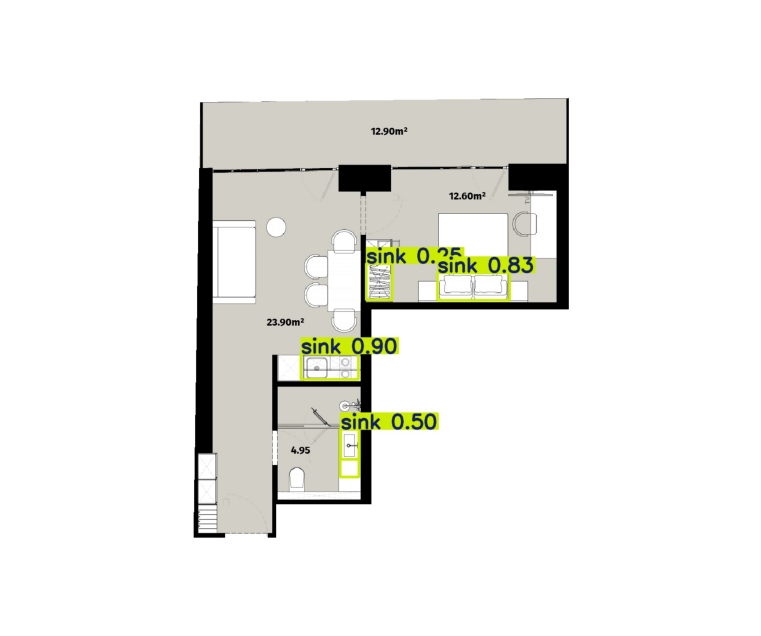

In [117]:
img_path = '../models/xrplace_furniture/customer_layouts/0dUsQJGX1GC4TLLKLemSoLp1aI3jaiR4R7PmKrVl.jpg' 
image = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(image)
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis("off")
plt.show()


In [ ]:
{1: ['sink'], 2: ['sink', 'sink'], 3: ['sink', 'sink'], 4: ['sink', 'sink']}

In [91]:
images_directory = '../models/xrplace_furniture/customer_layouts'
labels_directory = '../models/xrplace_furniture/customer_layouts/labels'

# Можно указать свои классы
custom_classes = ['door', 'window', 'bed', 'dining_table', 'toilet', 'sofa', 'round_table', 'sink', 'tub']

points = convert_all_bboxes_in_folder(images_directory, labels_directory, custom_classes)

objects = []
for image_name, bbox_list in points.items():
    for class_name, x, y in bbox_list:
        objects.append([class_name,(x,y)])
objects

📷 0dUsQJGX1GC4TLLKLemSoLp1aI3jaiR4R7PmKrVl: найдено 5 объектов
   - sink: центр (651, 726)
   - sink: центр (943, 563)
   - sink: центр (692, 885)
   - sink: центр (691, 902)
   - sink: центр (751, 553)


[['sink', (651, 726)],
 ['sink', (943, 563)],
 ['sink', (692, 885)],
 ['sink', (691, 902)],
 ['sink', (751, 553)]]

# Определение назначения помещения

In [109]:
def is_point_in_polygon(point, polygon):
    """
    Проверяет, находится ли точка внутри полигона.
    Используется алгоритм Ray Casting (проверка количества пересечений луча).
    
    Параметры:
        point (tuple): Координаты точки (x, y).
        polygon (list): Список координат вершин полигона [(x1, y1), (x2, y2), ...].
    
    Возвращает:
        bool: True, если точка внутри полигона, иначе False.
    """
    x, y = point
    n = len(polygon)
    inside = False
    
    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    
    return inside
def find_room_for_object(objects, rooms_data):
    """
    Определяет номер комнаты, в которой находится объект.
    
    Параметры:
        object_coords : Координаты объекта (x, y).
        rooms_data (list): Список комнат (из функции process_image), где каждая комната
                          представлена словарем {'room': номер, 'coordinates': [(x1,y1), ...]}.
    
    Возвращает:
        массив с номером комнаты и объектами внутри комнаты, или None, если не найден.
    """
    rooms_object = {}
    for object in objects:
        x, y = object[1]
        for room in rooms_data:
            room_id = room['room']
            polygon = room['coordinates']
            if is_point_in_polygon((x, y), polygon):
                if room_id not in rooms_object:
                    rooms_object[room_id] = []
                rooms_object[room_id].append(object[0])
    return rooms_object           

In [110]:
rooms = find_room_for_object(objects, room_coord[1])
rooms


{1: ['sink'], 2: ['sink', 'sink'], 3: ['sink', 'sink'], 4: ['sink', 'sink']}

In [87]:
# Классификация назначения помещения
furniture_to_room = {
     
    'bed': 'bedroom',            # кровать - спальня      
    'dining_table': 'kitchen',   # обеденный стол - столовая  
    'toilet': 'bathroom',        # туалет - ванная комната  
    'sofa': 'living_room',       # диван - гостиная  
    'round_table': 'living_room',# круглый стол - гостиная 
    'sink': 'kitchen',           # раковина -кухня 
    'tub': 'bathroom',           # ванна - ванная комната  
}



In [79]:
from collections import defaultdict

def map_objects_to_room_type(detected_objects, furniture_to_room):
    """
    Сопоставляет обнаруженные объекты с типом комнаты на основе словаря соответствий.
    
    Параметры:
        detected_objects (list): Список обнаруженных объектов (например, ['bed', 'sofa']).
        furniture_to_room (dict): Словарь соответствия объектов типам комнат.
    
    Возвращает:
        dict: Словарь с наиболее вероятным типом комнаты и статистикой:
              {
                  'most_likely': 'bedroom',  # Самый частый тип
                  'stats': {'bedroom': 2, 'living_room': 1},  # Количество объектов каждого типа
                  'objects': ['bed', 'wardrobe']  # Объекты, которые учтены в классификации
              }
              или None, если не удалось определить.
    """
    if not detected_objects:
        return None
    
    # Считаем количество объектов для каждого типа комнаты
    room_counts = defaultdict(int)
    valid_objects = []
    
    for obj in detected_objects:
        if obj in furniture_to_room:
            room_type = furniture_to_room[obj]
            room_counts[room_type] += 1
            valid_objects.append(obj)
    
    if not room_counts:
        return None
    
    # Находим наиболее часто встречающийся тип комнаты
    most_likely_room = max(room_counts.items(), key=lambda x: x[1])[0]
    
    return {
        'most_likely': most_likely_room,
        'stats': dict(room_counts),
        'objects': valid_objects
    }

In [85]:
objects[0][0]

'sink'

In [90]:
# Обнаруженные объекты в комнате
detected_objects = [objects[0][0]]

result = map_objects_to_room_type(detected_objects, furniture_to_room)
print(result)

{'most_likely': 'kitchen', 'stats': {'kitchen': 1}, 'objects': ['sink']}


## ✅ Финальный вывод
- Обучена модель, которая определяет на 2d планах помещений окна и двери
Графики в папке models/yolo_door_window_model_2
- Реализован функционал, который определяет координаты (абсолютные) цетров найденных bbox объектов.
- Реализован интерфейс для использования (через FASTAPI, репозиторий https://github.com/Izymka/plan_scanner)
- Метрики (IoU/mAP) позволяют объективно сравнивать модели

Возникли проблемы с решением 2-ой части, а именно с определением назначения помещения.
1. Реализовано:
- Обучена модель для распознавания мебели на плане помещения.
- Создан словарь соответствий между предметами и назначением помещений.
- Разработана функция, которая по координатам объекта и углов комнаты определяет тип помещения.
- Взята предобученная модель (из предоставленного репозитория) для определения координат углов помещения.

2. Возникшие сложности:
- Не удалось развернуть Docker-образ с исходной моделью детекции углов помещения.
- Тестирование на данных заказчика выявило ошибки:
- Модель определения мебели путает объекты (низкая точность на реальных планах).
- Модель детекции углов некорректно определяет количество комнат.

3. Принятое решение:
В связи с ограниченным временем проект сокращен до функционала детекции дверей и окон.
